# 车牌检测与识别

../../dataset/carplate/N17.jpeg
../../dataset/carplate/N139.jpeg
../../dataset/carplate/N37.jpeg
../../dataset/carplate/N36.jpeg
../../dataset/carplate/N57.jpeg


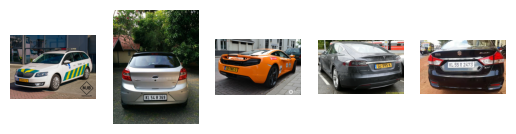

In [12]:
import os
import cv2
import matplotlib.pyplot as plt

root_dir = "../../dataset/carplate/"
img_list = [os.path.join(root_dir, item) for item in os.listdir(root_dir) if not item.startswith('.')][:5]

for i, img_path in enumerate(img_list):
    print(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1,5,i + 1)
    plt.imshow(img)
    plt.axis('off')


## 车牌的定位与识别如何实现？

- 定位：首先定位出车牌的位置，并从中分割出单个字符区域
- 识别：从单个字符区域中提取特征，并进行分类和检测

### 方法一：模板匹配

模板匹配是图像物体检测与识别中最直观的手段。

**核心思路：** 给定一张大图像，将待匹配模版遍历式地与大图像的所有区域进行匹配度量，取较高匹配度的区域为模板位置

首先，准备一张模板图像T，和待检测图像I如下

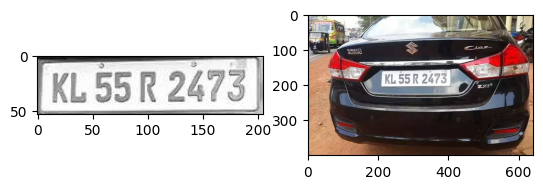

In [13]:
img_T = cv2.imread("../../dataset/carplate/T.png")
img_I = cv2.imread("../../dataset/carplate/N57.jpeg")

img_T = cv2.cvtColor(img_T, cv2.COLOR_BGR2RGB)
img_I = cv2.cvtColor(img_I, cv2.COLOR_BGR2RGB)

plt.subplot(1,2,1)
plt.imshow(img_T, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_I, cmap='gray')

然后，以T为模板，以滑动窗口的方式对原图进行遍历匹配

匹配时，随着计算方式的不同，有着不同的实现。

具体上，有以下几种方式进行计算

* TM_SQDIFF: 平方差匹配，计算每个像素点的平方差，最终求和
* TM_SQDIFF_NORMED: 归一化后的平方差的和
* TM_CCORR: 点乘后求和, 余弦
* TM_CCORR_NORMED: 归一化后的余弦
* TM_CCOEFF: 相关匹配, 模板减去均值与图像减去均值做余弦
* TM_CCOEFF_NORMED: 相关匹配归一化

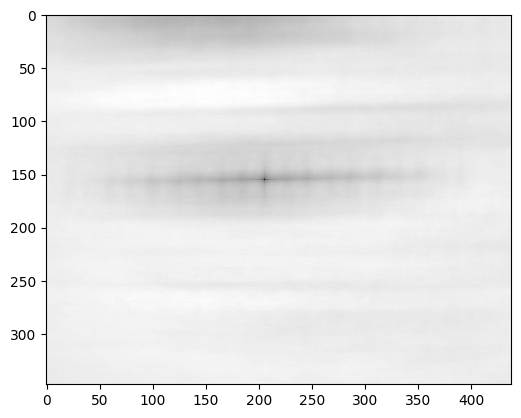

In [4]:
import numpy as np

mat_r = np.zeros([img_I.shape[0] - img_T.shape[0] + 1, 
                  img_I.shape[1] - img_T.shape[1] + 1])

for i in range(0, img_I.shape[0] - img_T.shape[0] + 1):
    for j in range(0, img_I.shape[1] - img_T.shape[1] + 1):
        tmp_i = img_I[i: i + img_T.shape[0], 
                      j: j + img_T.shape[1]]
        mat_r[i, j] = np.sum(np.power(img_T - tmp_i, 2))

plt.imshow(mat_r, cmap='gray')
plt.show()

In [5]:
location = np.where(mat_r == mat_r.min())
print(location)

(array([155]), array([205]))


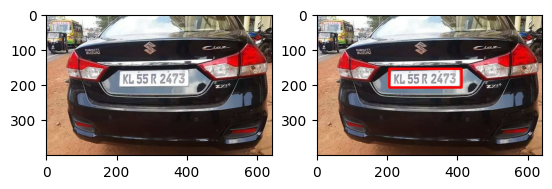

In [6]:
img = cv2.rectangle(img_I.copy(), (205, 155), (205 + img_T.shape[1], 155 + img_T.shape[0]), (255, 0, 0), 5)
plt.subplot(1, 2, 1)
plt.imshow(img_I, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.show()

### 缺点

模板匹配作为最直观的目标检测方法，采用滑动窗口逐个匹配的方式来实现目标的检测。

然而，模板匹配缺少鲁棒性，在具有形变、尺度变换、旋转或者透视变换的场景下存在较大的局限性。

通常，也可以结合图像金字塔、梯度变换等方式来解决旋转、尺度问题，但是依然缺少普适性。

此外，模板匹配的效率也非常低

### opencv实现

opencv也提供了优化后的接口实现模板检测。

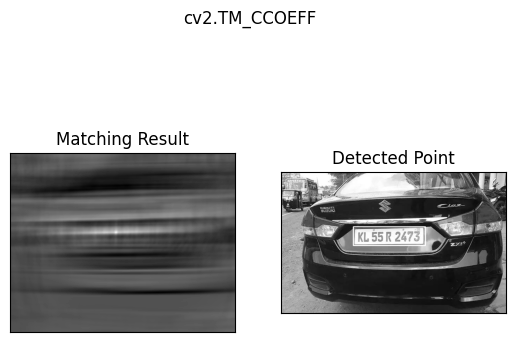

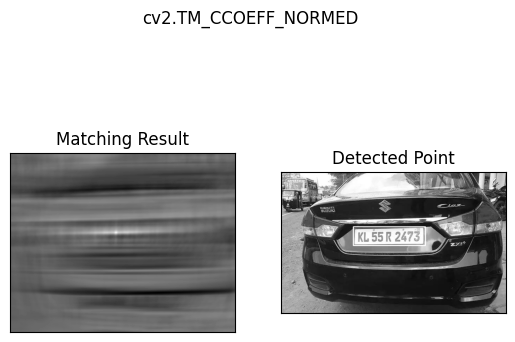

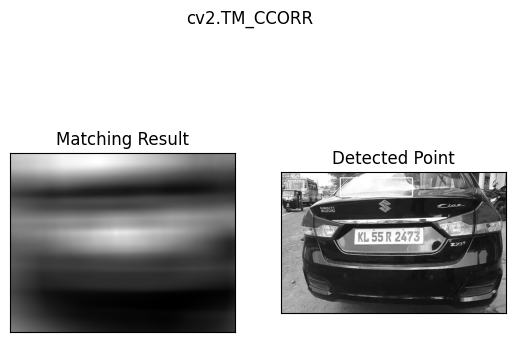

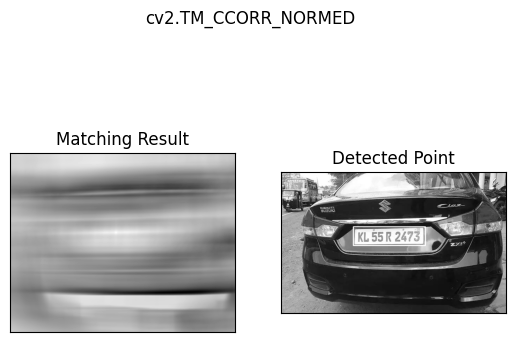

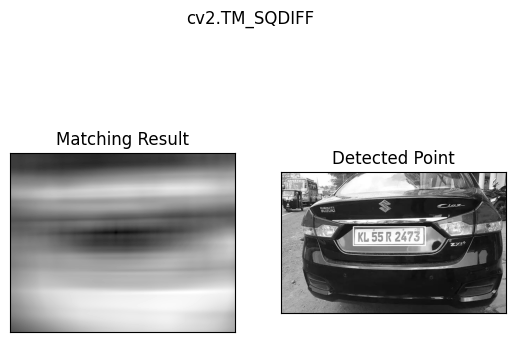

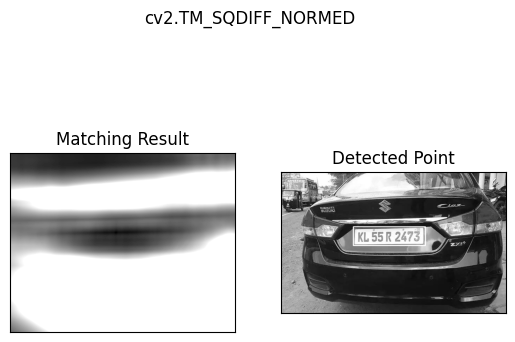

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('../../dataset/carplate/N57.jpeg',0)
img2 = img.copy()

template = cv2.imread('../../dataset/carplate/T.png',0)
w, h = template.shape[::-1]

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')

    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])

    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

## 方法二：图像处理方法

如何用图像处理的方法识别车牌？

车牌有什么特点？

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


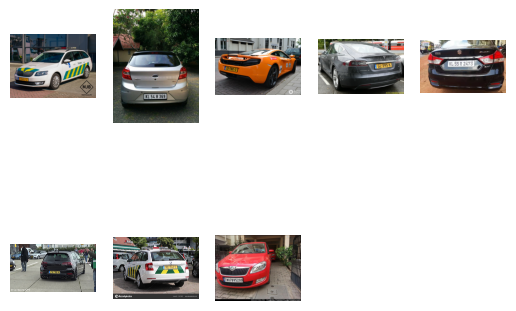

In [7]:
root_dir = "../../dataset/carplate/"
img_list = [os.path.join(root_dir, item) for item in os.listdir(root_dir) if not item.startswith('.')][:10]

for i, img_path in enumerate(img_list):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,i + 1)
    plt.imshow(img)
    plt.axis('off')

**车牌的特点**

1. 颜色: 国内车牌大多为蓝色和绿色(如何按颜色分割图像？)

2. 形状: 通常为矩形，也就是说他的边缘是一个闭合的四边形

3. 边缘: 通常车牌具有清晰的直线

### 按颜色的车牌区域分割

**颜色区域划分**

如何将固定的颜色划分出来？

二值化分割？

**相比于RGB，HSV更适合分割颜色**

以下是颜色在hsv中的数值对照表

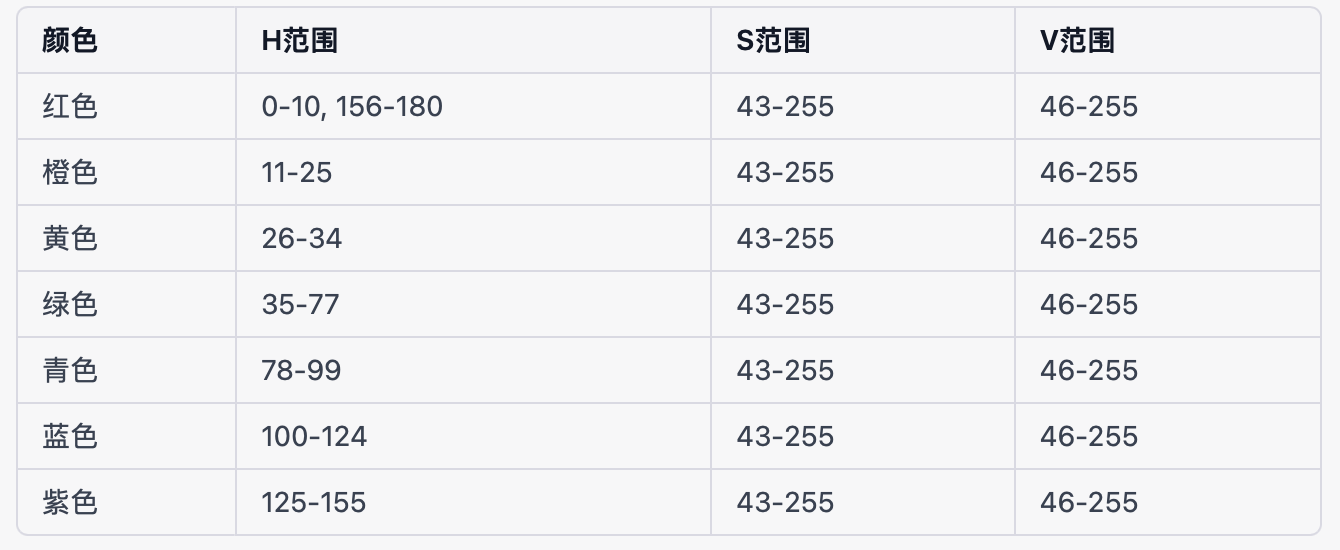

那么对于以下图像，可以简单地进行颜色分割。

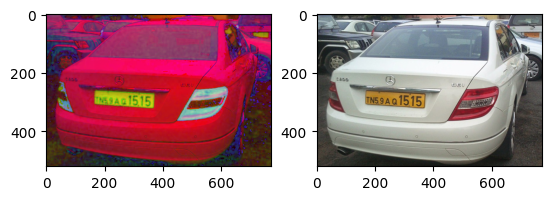

In [8]:
img = cv2.imread("../../dataset/carplate/N42.jpeg")

img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.subplot(121)
plt.imshow(hsv_img[:, :, ::-1])
plt.subplot(122)
plt.imshow(img2)

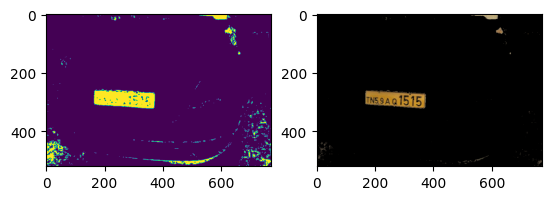

In [13]:
mask = np.ones(img.shape[:2])
mask[hsv_img[:, :, 0] < 15] = 0
mask[hsv_img[:, :, 0] >34] = 0
mask[hsv_img[:, :, 1] < 43] = 0
mask[hsv_img[:, :, 2] <46] = 0

img2[:, :, 0] = img2[:, :, 0] * mask
img2[:, :, 1] = img2[:, :, 1] * mask
img2[:, :, 2] = img2[:, :, 2] * mask


plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(img2)

### 课堂练习

通过形态学操作，轮廓填充等方法，截取出车牌区域。

通过透视变换等方法，来矫正车牌区域，得到一个正面形变的车牌。

### 本周作业

编写一个可以检测车牌位置的程序。

要求：

* 不限制方法，鼓励使用新思路，新方法
* 在邮件正文中写明所使用的方法流程，并贴上结果
* 测试数据中包含黄白两种车牌

截止日期：

2023年4月19日24:00